Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [2]:
df = pd.read_excel("/content/DrugReviewsLabel.xlsx")
df = df[['Drug Review','Label']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12586 entries, 0 to 12585
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Drug Review  11225 non-null  object 
 1   Label        851 non-null    float64
dtypes: float64(1), object(1)
memory usage: 196.8+ KB


In [4]:
df = df.dropna(subset=['Label'])
df = df.dropna(subset=['Drug Review'])
df.drop_duplicates(subset=['Drug Review'], keep = 'last', inplace = True)
df = df.reset_index()
df.drop(columns=['index'], inplace = True)
df['Label'] = df['Label'].astype('int')
df.sample(10)

,Drug Review,Label
631,I've been taking for 3 weeks. I do experience ...,1
350,Been on Lisiniprol for almost 3 years. Always ...,1
191,"When I first started taking Maxalt MLT, I bega...",0
477,I have PCOS and have always has irregular peri...,1
777,"""I've lost 77lbs taking this medication. It ma...",1
1,Went on after repeated Traaumatic brain injury...,0
756,"""Have been suffering for 18 years before someo...",0
235,My current favorite. Quick acting. No appare...,0
651,"""I have been experiencing tremendous constant ...",0
128,"For chronic migraine. 50mg then if needed, 50m...",1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Drug Review  847 non-null    object
 1   Label        847 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.4+ KB


In [6]:
x_train, x_test, y_train, y_test = train_test_split(df['Drug Review'], df['Label'], test_size=0.1, random_state=42)

In [7]:
max_len = 512
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500

In [8]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [9]:
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

4430

In [10]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

In [11]:
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

In [12]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (762, 512)
Shape of testing tensor:  (85, 512)


## Dense Layer

In [13]:
# Define parameter
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 24
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

In [15]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
24/24 - 1s - loss: 0.6872 - accuracy: 0.6168 - val_loss: 0.6859 - val_accuracy: 0.5882 - 1s/epoch - 54ms/step
Epoch 2/30
24/24 - 0s - loss: 0.6794 - accuracy: 0.6168 - val_loss: 0.6805 - val_accuracy: 0.5882 - 138ms/epoch - 6ms/step
Epoch 3/30
24/24 - 0s - loss: 0.6720 - accuracy: 0.6168 - val_loss: 0.6775 - val_accuracy: 0.5882 - 127ms/epoch - 5ms/step
Epoch 4/30
24/24 - 0s - loss: 0.6675 - accuracy: 0.6168 - val_loss: 0.6773 - val_accuracy: 0.5882 - 144ms/epoch - 6ms/step
Epoch 5/30
24/24 - 0s - loss: 0.6679 - accuracy: 0.6168 - val_loss: 0.6771 - val_accuracy: 0.5882 - 134ms/epoch - 6ms/step
Epoch 6/30
24/24 - 0s - loss: 0.6645 - accuracy: 0.6168 - val_loss: 0.6770 - val_accuracy: 0.5882 - 123ms/epoch - 5ms/step
Epoch 7/30
24/24 - 0s - loss: 0.6642 - accuracy: 0.6168 - val_loss: 0.6769 - val_accuracy: 0.5882 - 136ms/epoch - 6ms/step
Epoch 8/30
24/24 - 0s - loss: 0.6603 - accuracy: 0.6168 - val_loss: 0.6762 - val_accuracy: 0.5882 - 149ms/epoch - 6ms/step
Epoch 9/30
24/24 -

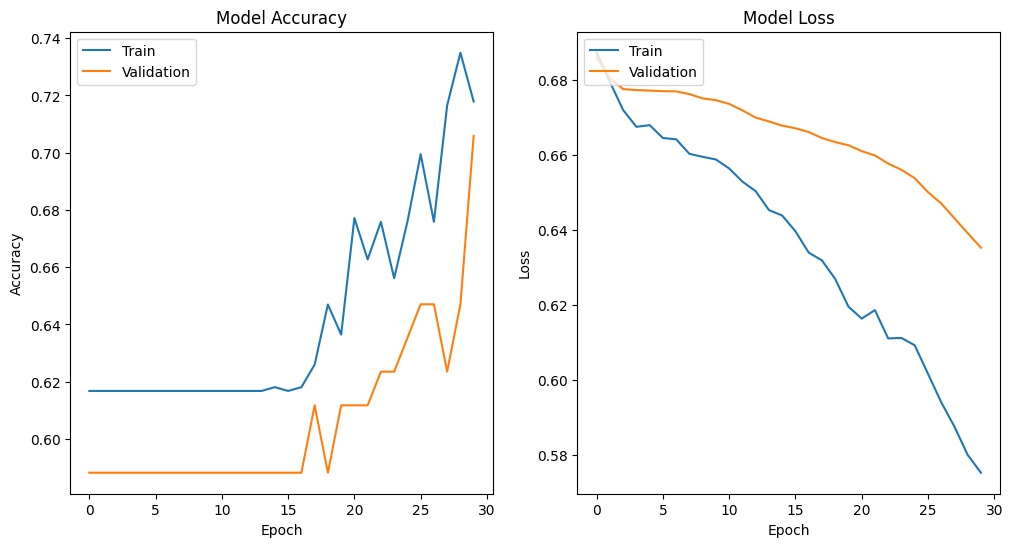

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [17]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 1s - loss: 0.5696 - accuracy: 0.7452 - 554ms/epoch - 185ms/step
1/1 - 0s - loss: 0.6353 - accuracy: 0.7059 - 35ms/epoch - 35ms/step
Train accuracy: 74.52
Valid accuracy: 70.59


In [60]:
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 48
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
24/24 - 2s - loss: 0.6863 - accuracy: 0.5945 - val_loss: 0.6832 - val_accuracy: 0.5882 - 2s/epoch - 69ms/step
Epoch 2/30
24/24 - 0s - loss: 0.6756 - accuracy: 0.6168 - val_loss: 0.6784 - val_accuracy: 0.5882 - 201ms/epoch - 8ms/step
Epoch 3/30
24/24 - 0s - loss: 0.6684 - accuracy: 0.6168 - val_loss: 0.6777 - val_accuracy: 0.5882 - 213ms/epoch - 9ms/step
Epoch 4/30
24/24 - 0s - loss: 0.6671 - accuracy: 0.6168 - val_loss: 0.6782 - val_accuracy: 0.5882 - 202ms/epoch - 8ms/step
Epoch 5/30
24/24 - 0s - loss: 0.6655 - accuracy: 0.6168 - val_loss: 0.6782 - val_accuracy: 0.5882 - 148ms/epoch - 6ms/step
Epoch 6/30
24/24 - 0s - loss: 0.6663 - accuracy: 0.6168 - val_loss: 0.6769 - val_accuracy: 0.5882 - 144ms/epoch - 6ms/step
Epoch 7/30
24/24 - 0s - loss: 0.6622 - accuracy: 0.6168 - val_loss: 0.6774 - val_accuracy: 0.5882 - 148ms/epoch - 6ms/step
Epoch 8/30
24/24 - 0s - loss: 0.6620 - accuracy: 0.6168 - val_loss: 0.6760 - val_accuracy: 0.5882 - 135ms/epoch - 6ms/step
Epoch 9/30
24/24 -

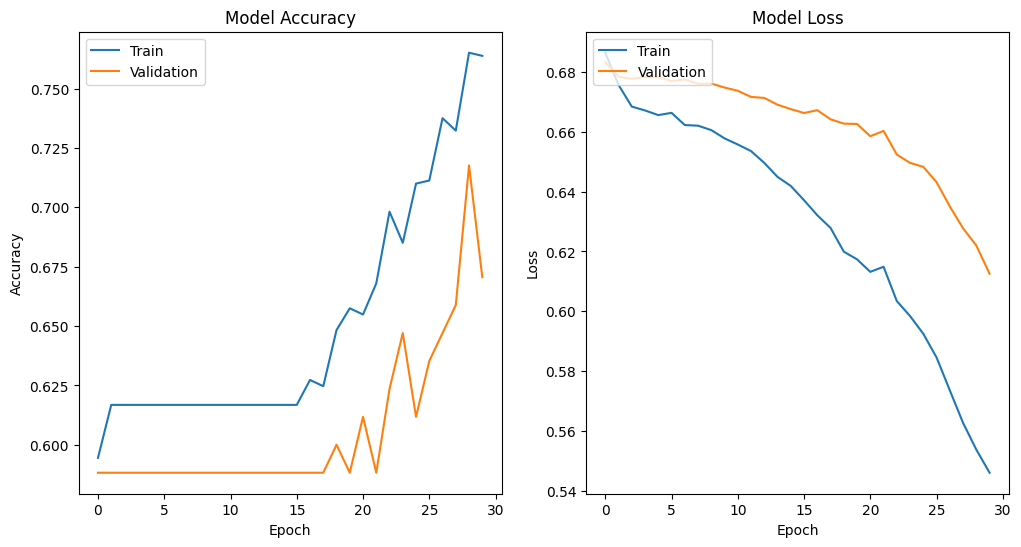

In [61]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [62]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 0s - loss: 0.5356 - accuracy: 0.8017 - 375ms/epoch - 125ms/step
1/1 - 0s - loss: 0.6126 - accuracy: 0.6706 - 24ms/epoch - 24ms/step
Train accuracy: 80.17
Valid accuracy: 67.06


In [66]:
vocab_size = 500
embedding_dim = 16
drop_value = 0.4
n_dense = 48
# Define Dense Model Architecture
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
24/24 - 1s - loss: 0.6871 - accuracy: 0.6063 - val_loss: 0.6840 - val_accuracy: 0.5882 - 1s/epoch - 57ms/step
Epoch 2/30
24/24 - 0s - loss: 0.6776 - accuracy: 0.6168 - val_loss: 0.6795 - val_accuracy: 0.5882 - 143ms/epoch - 6ms/step
Epoch 3/30
24/24 - 0s - loss: 0.6736 - accuracy: 0.6168 - val_loss: 0.6775 - val_accuracy: 0.5882 - 150ms/epoch - 6ms/step
Epoch 4/30
24/24 - 0s - loss: 0.6675 - accuracy: 0.6168 - val_loss: 0.6772 - val_accuracy: 0.5882 - 151ms/epoch - 6ms/step
Epoch 5/30
24/24 - 0s - loss: 0.6661 - accuracy: 0.6168 - val_loss: 0.6773 - val_accuracy: 0.5882 - 145ms/epoch - 6ms/step
Epoch 6/30
24/24 - 0s - loss: 0.6654 - accuracy: 0.6168 - val_loss: 0.6769 - val_accuracy: 0.5882 - 144ms/epoch - 6ms/step
Epoch 7/30
24/24 - 0s - loss: 0.6662 - accuracy: 0.6168 - val_loss: 0.6763 - val_accuracy: 0.5882 - 134ms/epoch - 6ms/step
Epoch 8/30
24/24 - 0s - loss: 0.6615 - accuracy: 0.6168 - val_loss: 0.6758 - val_accuracy: 0.5882 - 137ms/epoch - 6ms/step
Epoch 9/30
24/24 -

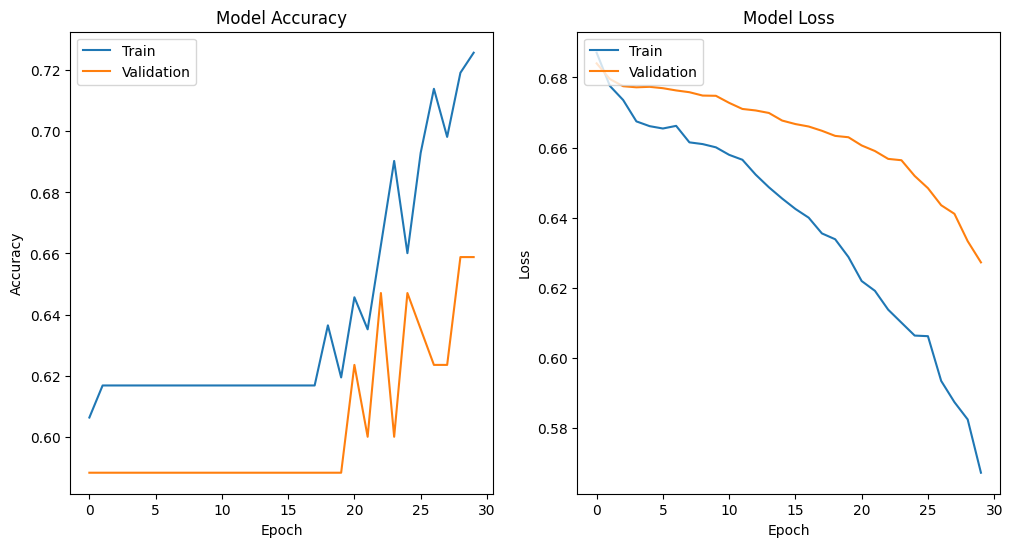

In [67]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [68]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 0s - loss: 0.5602 - accuracy: 0.7833 - 378ms/epoch - 126ms/step
1/1 - 0s - loss: 0.6273 - accuracy: 0.6588 - 26ms/epoch - 26ms/step
Train accuracy: 78.33
Valid accuracy: 65.88


## LSTM - 64 layers

In [69]:
n_lstm = 64
drop_lstm = 0.2
# Define LSTM Model
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
24/24 - 14s - loss: 0.6808 - accuracy: 0.6037 - val_loss: 0.6777 - val_accuracy: 0.5882 - 14s/epoch - 569ms/step
Epoch 2/30
24/24 - 10s - loss: 0.6722 - accuracy: 0.6168 - val_loss: 0.6782 - val_accuracy: 0.5882 - 10s/epoch - 406ms/step
Epoch 3/30
24/24 - 10s - loss: 0.6674 - accuracy: 0.6168 - val_loss: 0.6791 - val_accuracy: 0.5882 - 10s/epoch - 429ms/step
Epoch 4/30
24/24 - 8s - loss: 0.6658 - accuracy: 0.6168 - val_loss: 0.6794 - val_accuracy: 0.5882 - 8s/epoch - 347ms/step


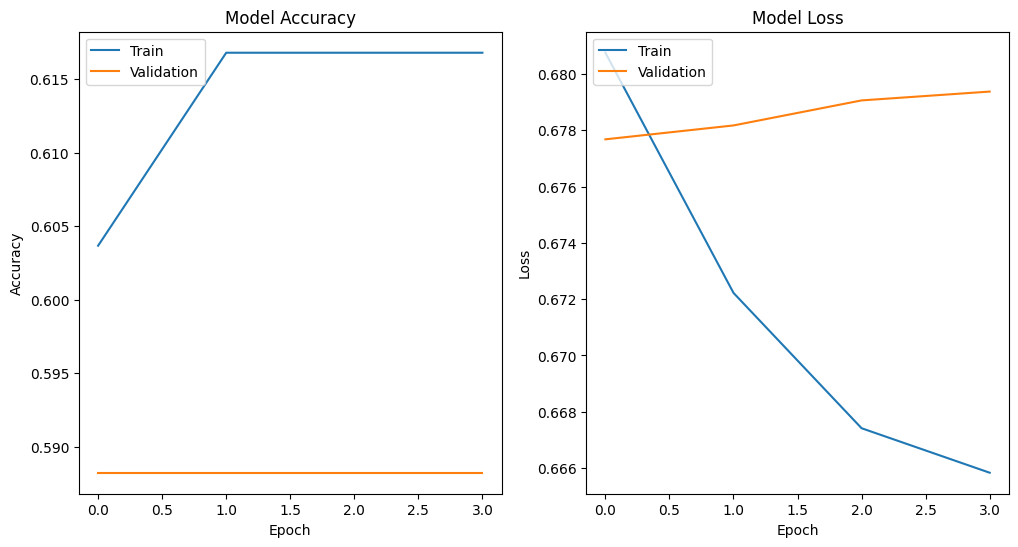

In [70]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [71]:
train_dense_results = model1.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model1.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 3s - loss: 0.6656 - accuracy: 0.6168 - 3s/epoch - 903ms/step
1/1 - 0s - loss: 0.6794 - accuracy: 0.5882 - 208ms/epoch - 208ms/step
Train accuracy: 61.68
Valid accuracy: 58.82


## LSTM - 0.2 drop

In [18]:
# Define parameter
n_lstm = 128
drop_lstm = 0.2
# Define LSTM Model
model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model1.add(SpatialDropout1D(drop_lstm))
model1.add(LSTM(n_lstm, return_sequences=False))
model1.add(Dropout(drop_lstm))
model1.add(Dense(1, activation='sigmoid'))

In [19]:
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [20]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model1.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
24/24 - 23s - loss: 0.6684 - accuracy: 0.5971 - val_loss: 0.6790 - val_accuracy: 0.5882 - 23s/epoch - 953ms/step
Epoch 2/30
24/24 - 17s - loss: 0.6675 - accuracy: 0.6168 - val_loss: 0.6787 - val_accuracy: 0.5882 - 17s/epoch - 699ms/step
Epoch 3/30
24/24 - 17s - loss: 0.6683 - accuracy: 0.6168 - val_loss: 0.6810 - val_accuracy: 0.5882 - 17s/epoch - 706ms/step
Epoch 4/30
24/24 - 17s - loss: 0.6672 - accuracy: 0.6168 - val_loss: 0.6790 - val_accuracy: 0.5882 - 17s/epoch - 705ms/step
Epoch 5/30
24/24 - 17s - loss: 0.6679 - accuracy: 0.6168 - val_loss: 0.6783 - val_accuracy: 0.5882 - 17s/epoch - 722ms/step
Epoch 6/30
24/24 - 18s - loss: 0.6674 - accuracy: 0.6168 - val_loss: 0.6812 - val_accuracy: 0.5882 - 18s/epoch - 767ms/step
Epoch 7/30
24/24 - 17s - loss: 0.6678 - accuracy: 0.6168 - val_loss: 0.6783 - val_accuracy: 0.5882 - 17s/epoch - 713ms/step
Epoch 8/30
24/24 - 17s - loss: 0.6677 - accuracy: 0.6168 - val_loss: 0.6788 - val_accuracy: 0.5882 - 17s/epoch - 693ms/step


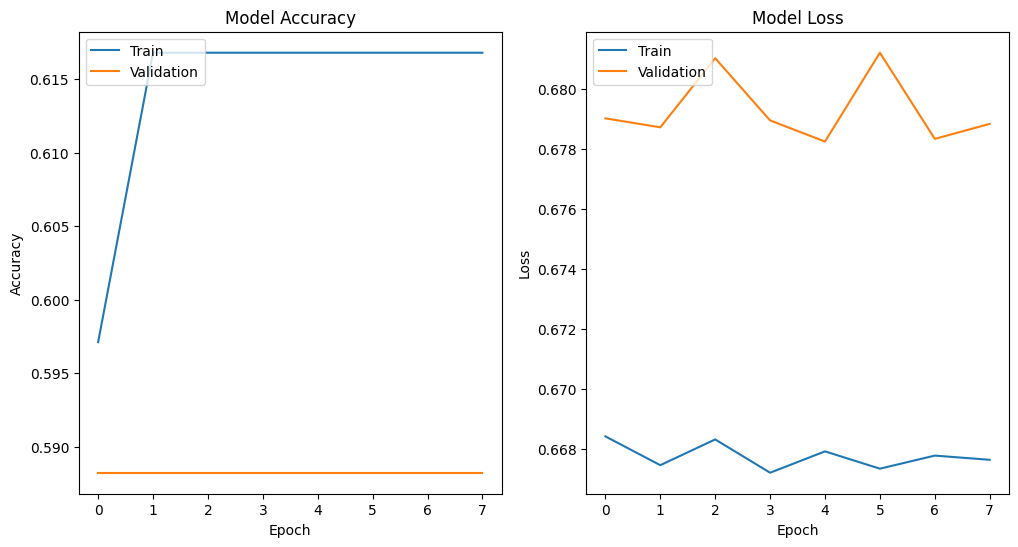

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [22]:
train_dense_results = model1.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model1.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 5s - loss: 0.6656 - accuracy: 0.6168 - 5s/epoch - 2s/step
1/1 - 1s - loss: 0.6788 - accuracy: 0.5882 - 600ms/epoch - 600ms/step
Train accuracy: 61.68
Valid accuracy: 58.82


## LSTM - 0.3 drop

In [26]:
# Define parameter
n_lstm = 128
drop_lstm = 0.3
# Define LSTM Model
model11 = Sequential()
model11.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model11.add(SpatialDropout1D(drop_lstm))
model11.add(LSTM(n_lstm, return_sequences=False))
model11.add(Dropout(drop_lstm))
model11.add(Dense(1, activation='sigmoid'))

In [27]:
model11.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [28]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model11.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
24/24 - 24s - loss: 0.6715 - accuracy: 0.6194 - val_loss: 0.6776 - val_accuracy: 0.5882 - 24s/epoch - 994ms/step
Epoch 2/30
24/24 - 20s - loss: 0.6656 - accuracy: 0.6168 - val_loss: 0.6974 - val_accuracy: 0.5882 - 20s/epoch - 814ms/step
Epoch 3/30
24/24 - 20s - loss: 0.6698 - accuracy: 0.6168 - val_loss: 0.6776 - val_accuracy: 0.5882 - 20s/epoch - 816ms/step
Epoch 4/30
24/24 - 29s - loss: 0.6679 - accuracy: 0.6168 - val_loss: 0.6798 - val_accuracy: 0.5882 - 29s/epoch - 1s/step


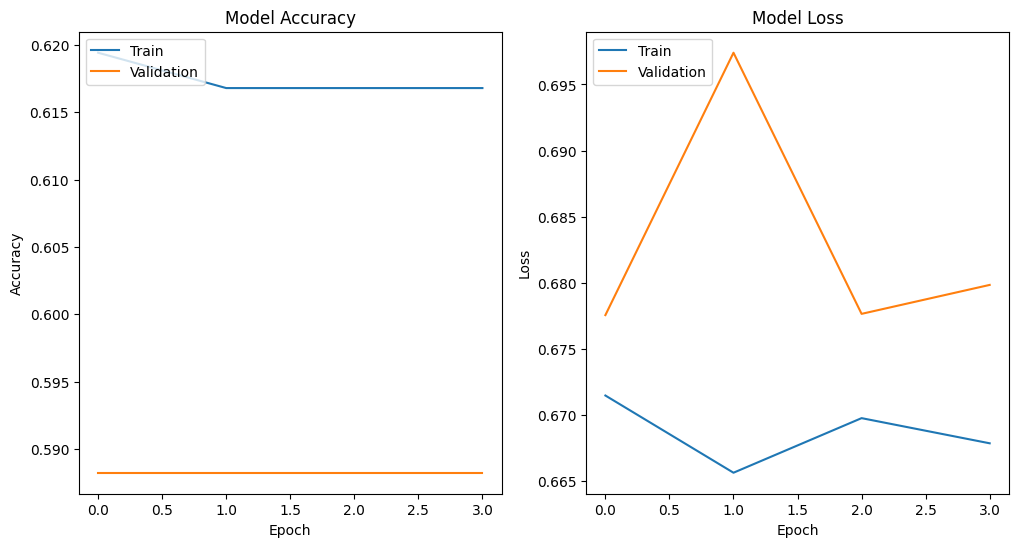

In [29]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [30]:
train_dense_results = model11.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model11.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 6s - loss: 0.6657 - accuracy: 0.6168 - 6s/epoch - 2s/step
1/1 - 1s - loss: 0.6798 - accuracy: 0.5882 - 706ms/epoch - 706ms/step
Train accuracy: 61.68
Valid accuracy: 58.82


## LSTM - 0.4 drop

In [31]:
# Define parameter
n_lstm = 128
drop_lstm = 0.4
# Define LSTM Model
model12 = Sequential()
model12.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model12.add(SpatialDropout1D(drop_lstm))
model12.add(LSTM(n_lstm, return_sequences=False))
model12.add(Dropout(drop_lstm))
model12.add(Dense(1, activation='sigmoid'))

model12.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model12.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
24/24 - 24s - loss: 0.6751 - accuracy: 0.6155 - val_loss: 0.6783 - val_accuracy: 0.5882 - 24s/epoch - 1s/step
Epoch 2/30
24/24 - 27s - loss: 0.6698 - accuracy: 0.6168 - val_loss: 0.6775 - val_accuracy: 0.5882 - 27s/epoch - 1s/step
Epoch 3/30
24/24 - 23s - loss: 0.6691 - accuracy: 0.6168 - val_loss: 0.6776 - val_accuracy: 0.5882 - 23s/epoch - 946ms/step
Epoch 4/30
24/24 - 18s - loss: 0.6644 - accuracy: 0.6168 - val_loss: 0.6810 - val_accuracy: 0.5882 - 18s/epoch - 733ms/step
Epoch 5/30
24/24 - 17s - loss: 0.6694 - accuracy: 0.6168 - val_loss: 0.6778 - val_accuracy: 0.5882 - 17s/epoch - 704ms/step


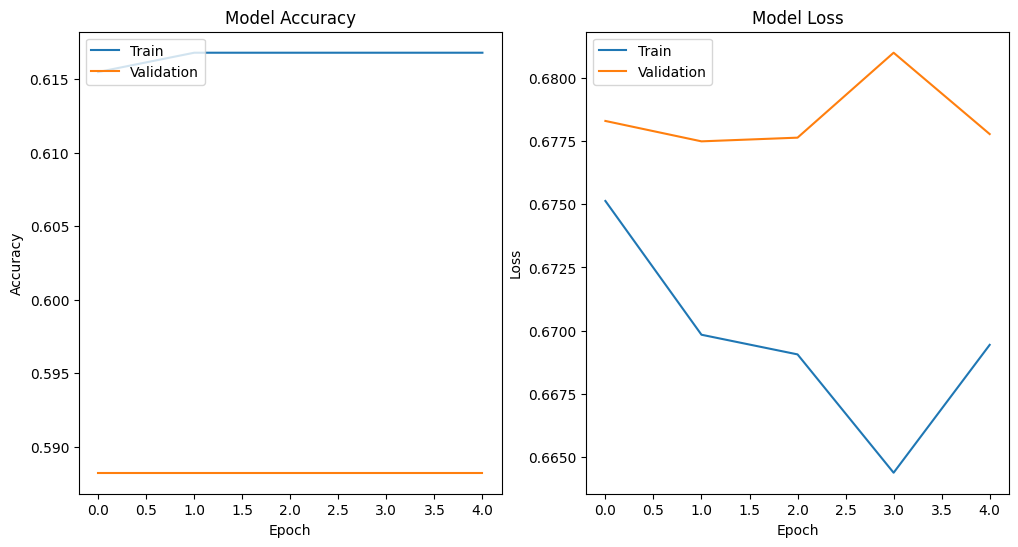

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [33]:
train_dense_results = model12.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model12.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 3s - loss: 0.6662 - accuracy: 0.6168 - 3s/epoch - 1s/step
1/1 - 1s - loss: 0.6778 - accuracy: 0.5882 - 519ms/epoch - 519ms/step
Train accuracy: 61.68
Valid accuracy: 58.82


## Bi-LSTM - 0.2 drop

In [34]:
n_lstm = 128
drop_lstm = 0.2
model2 = Sequential()
model2.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model2.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))

In [35]:
model2.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

In [36]:
num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 3)
history = model2.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),
                     callbacks = [early_stop],
                     verbose = 2)

Epoch 1/30
24/24 - 37s - loss: 0.6716 - accuracy: 0.6076 - val_loss: 0.6858 - val_accuracy: 0.5882 - 37s/epoch - 2s/step
Epoch 2/30
24/24 - 31s - loss: 0.6686 - accuracy: 0.6168 - val_loss: 0.6762 - val_accuracy: 0.5882 - 31s/epoch - 1s/step
Epoch 3/30
24/24 - 31s - loss: 0.6552 - accuracy: 0.6168 - val_loss: 0.6656 - val_accuracy: 0.5882 - 31s/epoch - 1s/step
Epoch 4/30
24/24 - 31s - loss: 0.6000 - accuracy: 0.6798 - val_loss: 0.6156 - val_accuracy: 0.6353 - 31s/epoch - 1s/step
Epoch 5/30
24/24 - 30s - loss: 0.5438 - accuracy: 0.7467 - val_loss: 0.5685 - val_accuracy: 0.7176 - 30s/epoch - 1s/step
Epoch 6/30
24/24 - 31s - loss: 0.4993 - accuracy: 0.8071 - val_loss: 0.5607 - val_accuracy: 0.7176 - 31s/epoch - 1s/step
Epoch 7/30
24/24 - 30s - loss: 0.4251 - accuracy: 0.8228 - val_loss: 0.5268 - val_accuracy: 0.7882 - 30s/epoch - 1s/step
Epoch 8/30
24/24 - 31s - loss: 0.3434 - accuracy: 0.8622 - val_loss: 0.5036 - val_accuracy: 0.7412 - 31s/epoch - 1s/step
Epoch 9/30
24/24 - 30s - loss: 0

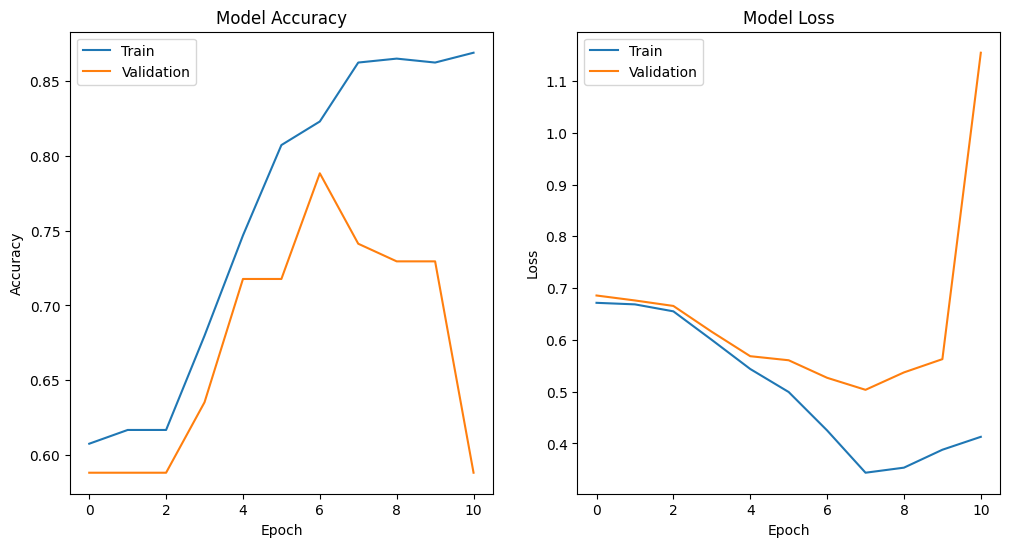

In [37]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [38]:
train_dense_results = model2.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model2.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 8s - loss: 0.9154 - accuracy: 0.6285 - 8s/epoch - 3s/step
1/1 - 1s - loss: 1.1547 - accuracy: 0.5882 - 534ms/epoch - 534ms/step
Train accuracy: 62.85
Valid accuracy: 58.82


## Bi-LSTM - 0.3 drop

In [39]:
n_lstm = 128
drop_lstm = 0.3
model21 = Sequential()
model21.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model21.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model21.add(Dropout(drop_lstm))
model21.add(Dense(1, activation='sigmoid'))

model21.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 3)
history = model21.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),
                     callbacks = [early_stop],
                     verbose = 2)

Epoch 1/30
24/24 - 35s - loss: 0.6733 - accuracy: 0.6155 - val_loss: 0.6769 - val_accuracy: 0.5882 - 35s/epoch - 1s/step
Epoch 2/30
24/24 - 30s - loss: 0.6647 - accuracy: 0.6168 - val_loss: 0.6669 - val_accuracy: 0.5882 - 30s/epoch - 1s/step
Epoch 3/30
24/24 - 31s - loss: 0.6199 - accuracy: 0.6693 - val_loss: 0.7210 - val_accuracy: 0.5059 - 31s/epoch - 1s/step
Epoch 4/30
24/24 - 31s - loss: 0.5654 - accuracy: 0.6785 - val_loss: 0.5862 - val_accuracy: 0.7059 - 31s/epoch - 1s/step
Epoch 5/30
24/24 - 30s - loss: 0.4841 - accuracy: 0.8084 - val_loss: 0.5781 - val_accuracy: 0.6941 - 30s/epoch - 1s/step
Epoch 6/30
24/24 - 30s - loss: 0.4331 - accuracy: 0.8189 - val_loss: 0.5062 - val_accuracy: 0.8118 - 30s/epoch - 1s/step
Epoch 7/30
24/24 - 30s - loss: 0.3813 - accuracy: 0.8491 - val_loss: 0.5489 - val_accuracy: 0.8000 - 30s/epoch - 1s/step
Epoch 8/30
24/24 - 31s - loss: 0.3372 - accuracy: 0.8622 - val_loss: 0.5085 - val_accuracy: 0.8000 - 31s/epoch - 1s/step
Epoch 9/30
24/24 - 32s - loss: 0

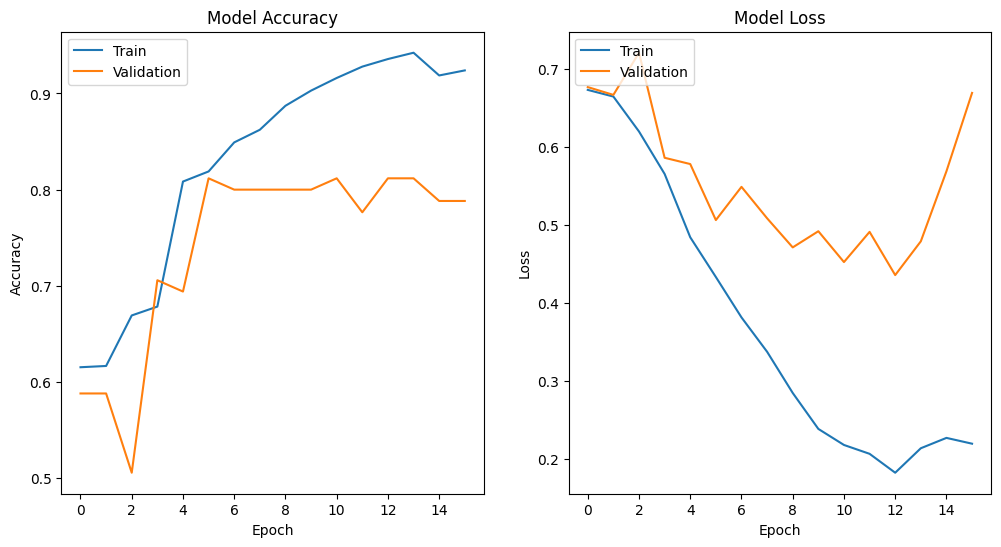

In [40]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [41]:
train_dense_results = model21.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model21.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 5s - loss: 0.1994 - accuracy: 0.9317 - 5s/epoch - 2s/step
1/1 - 1s - loss: 0.6694 - accuracy: 0.7882 - 907ms/epoch - 907ms/step
Train accuracy: 93.17
Valid accuracy: 78.82


## Bi-LSTM - 0.4 drop

In [42]:
n_lstm = 128
drop_lstm = 0.4
model22 = Sequential()
model22.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model22.add(Bidirectional(LSTM(n_lstm,
                              return_sequences = False)))
model22.add(Dropout(drop_lstm))
model22.add(Dense(1, activation='sigmoid'))

model22.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics=['accuracy'])

num_epochs = 30
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 3)
history = model22.fit(training_padded,
                     y_train,
                     epochs = num_epochs,
                     validation_data = (testing_padded, y_test),
                     callbacks = [early_stop],
                     verbose = 2)

Epoch 1/30
24/24 - 38s - loss: 0.6697 - accuracy: 0.6089 - val_loss: 0.6749 - val_accuracy: 0.5882 - 38s/epoch - 2s/step
Epoch 2/30
24/24 - 31s - loss: 0.6509 - accuracy: 0.6102 - val_loss: 0.6699 - val_accuracy: 0.5882 - 31s/epoch - 1s/step
Epoch 3/30
24/24 - 31s - loss: 0.6521 - accuracy: 0.6168 - val_loss: 0.6659 - val_accuracy: 0.5882 - 31s/epoch - 1s/step
Epoch 4/30
24/24 - 31s - loss: 0.6359 - accuracy: 0.6207 - val_loss: 0.6513 - val_accuracy: 0.5882 - 31s/epoch - 1s/step
Epoch 5/30
24/24 - 30s - loss: 0.5673 - accuracy: 0.6995 - val_loss: 0.6270 - val_accuracy: 0.6941 - 30s/epoch - 1s/step
Epoch 6/30
24/24 - 31s - loss: 0.5349 - accuracy: 0.7664 - val_loss: 0.5831 - val_accuracy: 0.7647 - 31s/epoch - 1s/step
Epoch 7/30
24/24 - 31s - loss: 0.5335 - accuracy: 0.7638 - val_loss: 0.5540 - val_accuracy: 0.7294 - 31s/epoch - 1s/step
Epoch 8/30
24/24 - 32s - loss: 0.3913 - accuracy: 0.8491 - val_loss: 0.4915 - val_accuracy: 0.7765 - 32s/epoch - 1s/step
Epoch 9/30
24/24 - 31s - loss: 0

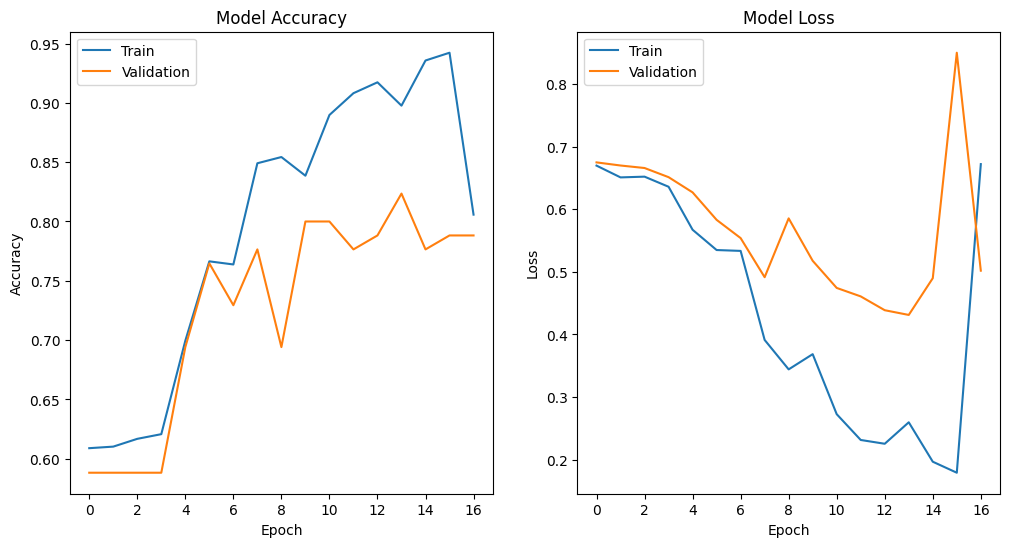

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [44]:
train_dense_results = model22.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model22.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 5s - loss: 0.3053 - accuracy: 0.9211 - 5s/epoch - 2s/step
1/1 - 1s - loss: 0.5019 - accuracy: 0.7882 - 852ms/epoch - 852ms/step
Train accuracy: 92.11
Valid accuracy: 78.82


## GRU

In [46]:
model3 = Sequential()
model3.add(Embedding(vocab_size,
                     embedding_dim,
                     input_length = max_len))
model3.add(SpatialDropout1D(0.4))
model3.add(GRU(128, return_sequences = False))
model3.add(Dropout(0.4))
model3.add(Dense(1, activation = 'sigmoid'))

In [47]:
model3.compile(loss = 'binary_crossentropy',
                       optimizer = 'adam',
                       metrics=['accuracy'])

In [48]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model3.fit(training_padded,
                     y_train,
                     epochs=num_epochs,
                     validation_data=(testing_padded, y_test),
                     callbacks =[early_stop],
                     verbose=2)

Epoch 1/30
24/24 - 16s - loss: 0.6723 - accuracy: 0.6168 - val_loss: 0.6815 - val_accuracy: 0.5882 - 16s/epoch - 662ms/step
Epoch 2/30
24/24 - 12s - loss: 0.6663 - accuracy: 0.6168 - val_loss: 0.6807 - val_accuracy: 0.5882 - 12s/epoch - 516ms/step
Epoch 3/30
24/24 - 11s - loss: 0.6674 - accuracy: 0.6168 - val_loss: 0.6787 - val_accuracy: 0.5882 - 11s/epoch - 465ms/step
Epoch 4/30
24/24 - 12s - loss: 0.6677 - accuracy: 0.6168 - val_loss: 0.6784 - val_accuracy: 0.5882 - 12s/epoch - 520ms/step
Epoch 5/30
24/24 - 13s - loss: 0.6677 - accuracy: 0.6168 - val_loss: 0.6775 - val_accuracy: 0.5882 - 13s/epoch - 538ms/step
Epoch 6/30
24/24 - 13s - loss: 0.6719 - accuracy: 0.6168 - val_loss: 0.6775 - val_accuracy: 0.5882 - 13s/epoch - 543ms/step
Epoch 7/30
24/24 - 14s - loss: 0.6658 - accuracy: 0.6168 - val_loss: 0.6787 - val_accuracy: 0.5882 - 14s/epoch - 573ms/step
Epoch 8/30
24/24 - 13s - loss: 0.6684 - accuracy: 0.6168 - val_loss: 0.6778 - val_accuracy: 0.5882 - 13s/epoch - 542ms/step


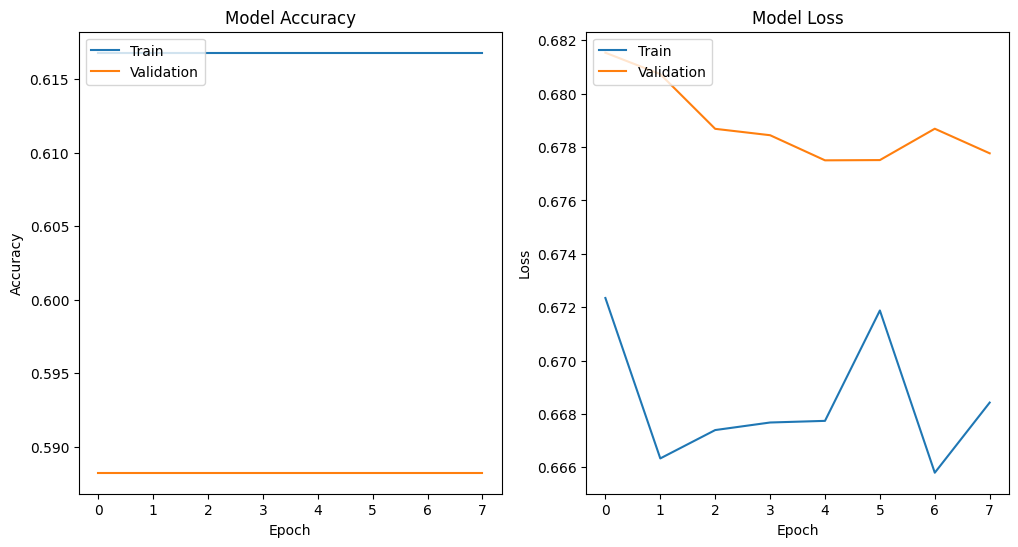

In [49]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [50]:
train_dense_results = model3.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model3.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

3/3 - 2s - loss: 0.6662 - accuracy: 0.6168 - 2s/epoch - 819ms/step
1/1 - 0s - loss: 0.6778 - accuracy: 0.5882 - 310ms/epoch - 310ms/step
Train accuracy: 61.68
Valid accuracy: 58.82


In [ ]:
predict_review = ["severe dry mouth+no saliva+damage to theet",\
                  "After my first week I woke up with half of my tongue swollen I was rushed to the ER.I was put on life support for six and a half days.",\
                  "I was warned of side effects such as a dry cough or light headedness if standing up too fast. Been on this for 2 months now with no sides to speak of.  BP dropped from 165/110 to 114/65.  So far so good.",\
                  "Extreme dry coughing",\
                  "works great  maintaining  blood pressure",\
                  "I've been using this medication for about 5 years. This medication works wonderful keeping my blood pressure under control however, within the last year I've started developing a common cough and, I've NEVER had a cough as such especially when I experience laughter. Nothing's perfect but, hopefully my Doctor can prescribe me a new blood pressure brand medication without this coughing side affect.",\
                  "After my first week of using this medicine, I woke up with half of my tongue swollen I was rushed to the ER.I was put on life support for six and a half days."]

def predict_side_effect(predict_review):
  new_seq = tokenizer.texts_to_sequences(predict_review)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model2.predict(padded))

predict_side_effect(predict_review)

1/1 [==============================] - 0s 108ms/step


array([[0.9300066 ],
       [0.0916375 ],
       [0.9847314 ],
       [0.9540738 ],
       [0.1263857 ],
       [0.5610404 ],
       [0.03305376]], dtype=float32)

In [45]:
predict_review = ["severe dry mouth+no saliva+damage to theet",\
                  "After my first week I woke up with half of my tongue swollen I was rushed to the ER.I was put on life support for six and a half days.",\
                  "I was warned of side effects such as a dry cough or light headedness if standing up too fast. Been on this for 2 months now with no sides to speak of.  BP dropped from 165/110 to 114/65.  So far so good.",\
                  "Extreme dry coughing",\
                  "works great  maintaining  blood pressure",\
                  "I've been using this medication for about 5 years. This medication works wonderful keeping my blood pressure under control however, within the last year I've started developing a common cough and, I've NEVER had a cough as such especially when I experience laughter. Nothing's perfect but, hopefully my Doctor can prescribe me a new blood pressure brand medication without this coughing side affect.",\
                  "After my first week of using this medicine, I woke up with half of my tongue swollen I was rushed to the ER.I was put on life support for six and a half days."]

def predict_side_effect(predict_review):
  new_seq = tokenizer.texts_to_sequences(predict_review)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model21.predict(padded))

predict_side_effect(predict_review)

1/1 [==============================] - 1s 945ms/step


array([[0.88631237],
       [0.06553943],
       [0.99347264],
       [0.8670844 ],
       [0.03984322],
       [0.8793161 ],
       [0.02256876]], dtype=float32)

In [73]:
predict_review = ["severe dry mouth+no saliva+damage to theet",\
                  "After my first week I woke up with half of my tongue swollen I was rushed to the ER.I was put on life support for six and a half days.",\
                  "I was warned of side effects such as a dry cough or light headedness if standing up too fast. Been on this for 2 months now with no sides to speak of.  BP dropped from 165/110 to 114/65.  So far so good.",\
                  "Extreme dry coughing",\
                  "works great  maintaining  blood pressure",\
                  "I've been using this medication for about 5 years. This medication works wonderful keeping my blood pressure under control however, within the last year I've started developing a common cough and, I've NEVER had a cough as such especially when I experience laughter. Nothing's perfect but, hopefully my Doctor can prescribe me a new blood pressure brand medication without this coughing side affect.",\
                  "After my first week of using this medicine, I woke up with half of my tongue swollen I was rushed to the ER.I was put on life support for six and a half days."]

def predict_side_effect(predict_review):
  new_seq = tokenizer.texts_to_sequences(predict_review)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model22.predict(padded))

predict_side_effect(predict_review)

1/1 [==============================] - 2s 2s/step


array([[0.9237552 ],
       [0.14872396],
       [0.8695072 ],
       [0.95558435],
       [0.09559008],
       [0.23355931],
       [0.11721604]], dtype=float32)